# Dropsondes dataset JOANNE

The following script exemplifies the access and usage of dropsonde data measured 
during EUREC4A - ATOMIC.  

More information on the dataset can be found at https://github.com/Geet-George/JOANNE.
If you have questions or if you would like to use the data for a publication, please don't hesitate to get in contact with the dataset authors as stated in the dataset attributes `contact` and `author` list.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from functools import reduce

import eurec4a
from intake import open_catalog

## Get data
* To load the data we first load the EUREC4A meta data catalogue. More information on the catalog can be found [here](https://github.com/eurec4a/eurec4a-intake#eurec4a-intake-catalogue).

In [3]:
# cat = eurec4a.get_intake_catalog()
cat = open_catalog("https://raw.githubusercontent.com/tmieslinger/eurec4a-intake/dropsonde_reorganisation/catalog.yml")
list(cat)

['radiosondes', 'barbados', 'dropsondes', 'HALO', 'p3']

* We can funrther specify the platform, instrument, if applicable dataset level or variable name, and pass it on to dask.

*Note: have a look at the attributes of the xarray dataset `ds` for all relevant information on the dataset, such as author, contact, or citation infromation.*

In [4]:
ds = cat.HALO.dropsondes.JOANNE.level3.to_dask().load()
ds

<xarray.Dataset>
Dimensions:          (alt: 1001, nv: 2, sounding: 1064)
Coordinates:
  * alt              (alt) int64 0 10 20 30 40 50 ... 9960 9970 9980 9990 10000
    lat              (sounding, alt) float32 nan 13.844528 13.844562 ... nan nan
    launch_time      (sounding) datetime64[ns] 2020-01-19T16:55:28 ... 2020-0...
    lon              (sounding, alt) float32 nan -55.268475 ... nan nan
  * sounding         (sounding) int64 0 1 2 3 4 5 ... 1059 1060 1061 1062 1063
Dimensions without coordinates: nv
Data variables:
    N_gps            (sounding, alt) float32 0.0 2.0 2.0 2.0 ... nan nan nan nan
    N_ptu            (sounding, alt) float32 1.0 2.0 2.0 2.0 ... nan nan nan nan
    PW               (sounding) float32 26.91856 29.85565 ... 28.478218 29.15732
    alt_bnds         (alt, nv) float64 -5.0 5.0 5.0 ... 9.995e+03 1.000e+04
    flight_height    (sounding) float32 9603.551 9616.252 ... 2682.56 2700.5784
    flight_lat       (sounding) float32 13.865528 13.279237 ... 13.7574 14.3066
    flight_lon       (sounding) float32 -55.260445 -57.91843 ... -55.9812
    low_height_flag  (sounding) float64 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
    p                (sounding, alt) float32 nan 101292.84 101178.2 ... nan nan
    platform         (sounding) object 'HALO' 'HALO' 'HALO' ... 'P3' 'P3' 'P3'
    q                (sounding, alt) float32 0.015249539 0.015137844 ... nan nan
    rh               (sounding, alt) float32 nan 0.72422 0.714776 ... nan nan
    sonde_id         (sounding) object 'HALO-0119_s02' ... 'P3-0211_s43'
    ta               (sounding, alt) float32 nan 299.04117 298.9365 ... nan nan
    theta            (sounding, alt) float32 297.89514 297.94595 ... nan nan
    u                (sounding, alt) float32 nan -8.915563 -9.055702 ... nan nan
    v                (sounding, alt) float32 nan -3.7457278 ... nan nan
    wdir             (sounding, alt) float32 nan 67.2115 67.27524 ... nan nan
    wspd             (sounding, alt) float32 nan 9.670484 9.817867 ... nan nan
Attributes:
    ASPEN-version:           BatchAspen v3.4.3
    AVAPS-Software-version:  Version 4.1.2
    Conventions:             CF-1.8
    JOANNE-version:          0.7.0+2.g4a878b3.dirty
    author:                  Geet George
    author_email:            geet.george@mpimet.mpg.de
    campaign_id:             EUREC4A
    creation_time:           2020-08-06 09:58:16.927582 UTC
    featureType:             trajectory
    instrument_id:           Vaisala RD-41
    product_id:              Level-3
    project_id:              JOANNE
    title:                   EUREC4A JOANNE Level-3

## Load HALO flight phase information
All HALO flights were split up into flight phases or segments to allow for a precise selection in time and space of a circle or calibration pattern. For more information have a look at the respective [github repository](https://github.com/eurec4a/flight-phase-separation#segmentation-of-flights-during-eurec4a).

In [5]:
meta = eurec4a.get_flight_segments()

In [6]:
segments = [{**s,
             "platform_id": platform_id,
             "flight_id": flight_id
            }
            for platform_id, flights in meta.items()
            for flight_id, flight in flights.items()
            for s in flight["segments"]
           ]

In [7]:
segments_by_segment_id = {s["segment_id"]: s for s in segments}

In [8]:
segments_ordered_by_start_time = list(sorted(segments, key=lambda s: s["start"]))

We select all `dropsondes` with the quality flag `GOOD` from the first circle on February 5.

In [9]:
first_circle_Feb05 = [s["segment_id"]
                 for s in segments_ordered_by_start_time
                 if "circle" in s["kinds"]
                 and s["start"].date() == datetime.date(2020,2,5)
                 and s["platform_id"] == "HALO"
                ][0]
first_circle_Feb05

'HALO-0205_c1'

In [11]:
dropsonde_ids = segments_by_segment_id[first_circle_Feb05]["dropsondes"]["GOOD"]
dropsonde_ids

['HALO-0205_s01',
 'HALO-0205_s02',
 'HALO-0205_s03',
 'HALO-0205_s04',
 'HALO-0205_s05',
 'HALO-0205_s06',
 'HALO-0205_s07',
 'HALO-0205_s08',
 'HALO-0205_s09',
 'HALO-0205_s10',
 'HALO-0205_s12']

We transfer the information from our flight segment selection to the dropsondes data in the xarray dataset.

In [12]:
selection_mask = reduce(lambda a, b: a | b, [ds.sonde_id==d for d in dropsonde_ids])

In [13]:
ds_selection = ds.isel(sounding=selection_mask)

## Plots
Figure 1: Temperature and relative humidity profiles of selected sondes.  
You can get a list of available variables in the dataset from `ds_selection.variables.keys()`  
*Note: fetching the data and displaying it might take a few seconds*

In [14]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 14

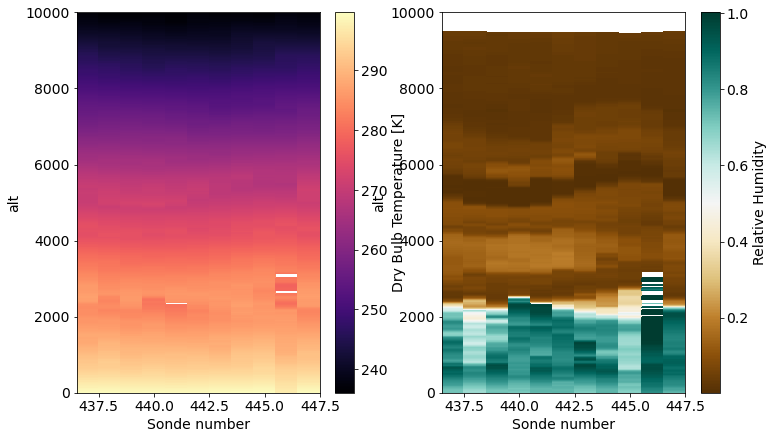

In [15]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,7))
ds_selection.ta.T.plot(ax=ax0, cmap="magma")
ds_selection.rh.T.plot(ax=ax1, cmap="BrBG")